In [72]:
from simpegem1d import *
from SimPEG import *
from simpegEMIP import SEInvImpulseProblem, SESurvey
import matplotlib as mpl
mpl.rcParams["font.size"] = 16
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [73]:
def ColeSE(time, eta, tau, beta):    
    return eta*np.exp(-(time/tau)**beta)
def ColeSEImpulse(time, eta, tau, beta):    
    return eta*beta/time*((time/tau)**beta)*np.exp(-(time/tau)**beta)
def ColeSEImpulseApprox(time, eta, tau, beta):    
    return eta*beta/time*((time/tau)**beta)
def ColeColeSeigel(f, sigmaInf, eta, tau, c):
    w = 2*np.pi*f
    return sigmaInf*(1 - eta/(1 + (1j*w*tau)**c))

In [74]:
from SimPEG import Mesh

In [75]:
# time = np.logspace(-3,-2, 101)
# timeout = np.logspace(-4.5,-2.5, 31)
# timemesh = Mesh.TensorMesh([time[1:]-time[:-1]], [time[0]])
# Pdt = timemesh.getInterpolationMat(timeout,'CC')*timemesh.faceDiv
# out = ColeSE(time, eta, 0.1, 0.5)
# plt.loglog(timeout, -Pdt*out, '.')
# plt.loglog(time, ColeSEImpulse(time, eta, 0.1, 0.5))

1 0.1 0.005 0.2
1 0.1 0.005 0.4
1 0.1 0.005 0.6
1 0.1 0.005 0.8
1 0.1 0.005 1.0


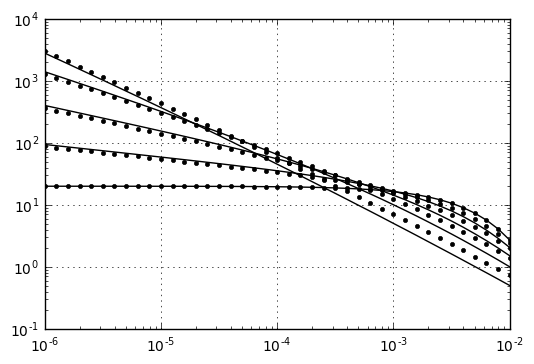

In [76]:
c_temp = np.arange(5)*0.2 + 0.2
for c in c_temp:
#     siginf, eta, tau, c = 1, 0.1, 0.01, 0.7
    siginf, eta, tau = 1, 0.1, 0.005
    time = np.logspace(-6,np.log10(0.01), 41)
    true = ColeSEImpulse(time, eta, tau, c)
    approx = ColeSEImpulseApprox(time, eta, tau, c)

    # plt.loglog(time, true, 'k', lw=1)
    # plt.loglog(time, approx, 'r.')
    # time = np.logspace(-3,np.log10(4), 41)
    wt, tbase, omega_int = DigFilter.setFrequency(time)
    frequency = omega_int / (2*np.pi)
    print siginf, eta, tau, c
    sigma = ColeColeSeigel(frequency, siginf, eta, tau, c)
    sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)
    plt.loglog(time, -sigTCole, 'k', lw=1)
    plt.loglog(time, true, 'k.')
    plt.grid(True)

In [65]:
siginf, eta, tau, c = 1, 0.1, 0.005, 0.8   
sigma = ColeColeSeigel(frequency, siginf, eta, tau, c)
sigTCole = DigFilter.transFiltImpulse(sigma, wt, tbase, omega_int, time, tol=1e-12)

In [59]:
wires = Maps.Wires(('eta', 1), ('tau', 1), ('c', 1))
taumap = Maps.ExpMap(nP=1)*wires.tau

In [60]:
survey = SESurvey()
dtrue = -sigTCole
survey.dobs = dtrue
m1D = Mesh.TensorMesh([np.ones(3)])
prob = SEInvImpulseProblem(m1D, etaMap = wires.eta, tauMap = taumap, cMap=wires.c)
prob.time = time
prob.pair(survey)
eta0, tau0, c0 = eta, tau, c
m0 = np.r_[eta0, np.log(tau0), c0]

survey.dpred(m0)

array([ 87.78834965,  83.81859652,  80.02475735,  76.39850864,
        72.93184207,  69.61704188,  66.44666193,  63.41350271,
        60.51058782,  57.73114001,  55.06855665,  52.51638447,
        50.06829368,  47.71805126,  45.45949393,  43.28650057,
        41.19296507,  39.17276993,  37.21976202,  35.32773208,
        33.49040033,  31.70141154,  29.95434408,  28.24273897,
        26.56015684,  24.90027281,  23.25702147,  21.6248064 ,
        19.99878989,  18.37527806,  16.75221306,  15.12977449,
        13.51107441,  11.90290073,  10.31641926,   8.7676863 ,
         7.27775693,   5.87211731,   4.5791574 ,   3.42748292,   2.4420996 ])

In [62]:
perc = 0.01
dmisfitpeta = DataMisfit.l2_DataMisfit(survey)
dmisfitpeta.Wd = 1/(abs(survey.dobs)*perc)
reg = Regularization.BaseRegularization(m1D)
opt = Optimization.ProjectedGNCG(maxIter = 3)
invProb = InvProblem.BaseInvProblem(dmisfitpeta, reg, opt)
# Create an inversion object
target = Directives.TargetMisfit()
betaSch = Directives.BetaSchedule(coolingFactor=1, coolingRate=1)
# invProb.beta = 0.
inv = Inversion.BaseInversion(invProb, directiveList=[betaSch, target])
reg.mref = 0.*m0
prob.counter = opt.counter = Utils.Counter()
opt.LSshorten = 0.5
opt.remember('xc')
opt.tolX = 1e-20
opt.tolF = 1e-20
opt.tolG = 1e-20
opt.eps = 1e-20
# opt.lower = 0.
mopt = inv.run(m0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same Solver and solverOpts as the problem***
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+00  1.31e+03  1.44e+01  1.32e+03    8.81e+04      0              
   1  1.00e+00  4.24e+02  1.44e+01  4.38e+02    6.97e+03      0              
   2  1.00e+00  3.72e+01  1.53e+01  5.26e+01    6.07e+03      0   Skip BFGS  
   3  1.00e+00  3.51e+01  1.53e+01  5.05e+01    3.26e+02      0              
------------------------- STOP! -------------------------
0 : |fc-fOld| = 2.0731e+00 <= tolF*(1+|f0|) = 1.3244e-17
0 : |xc-x_last| = 1.1408e-03 <= tolX*(1+|x0|) = 6.3593e-20
0 : |proj(x-g)-x|    = 3.2616e+02 <= tolG          = 1.0000e-20
0 : |proj(x-g)-x|    = 3.26

True      eta, tau and beta = 1e-01, 5e-03 and 0.8
Initial   eta, tau and beta = 9e-02, 4e-03 and 0.8
Estimated eta, tau and beta = 1e-01, 5e-03 and 0.8


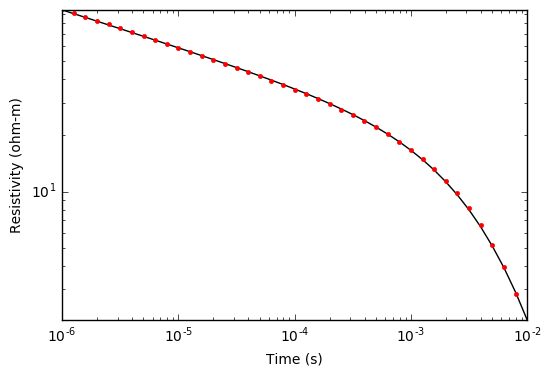

In [63]:
nskip=1
plt.loglog(prob.time[::nskip], survey.dobs[::nskip], 'k', lw=1)
plt.loglog(prob.time[::nskip], invProb.dpred[::nskip], 'r.')
vmin, vmax = survey.dobs[::nskip].min(), survey.dobs[::nskip].max()
ylim(vmin, vmax)
# legend(("pred", "obs"))
print ("True      eta, tau and beta = %.e, %.e and %3.1f")%(eta, tau, c)
print ("Initial   eta, tau and beta = %.e, %.e and %3.1f")%(mopt[0], np.exp(mopt[1]), mopt[2])
print ("Estimated eta, tau and beta = %.e, %.e and %3.1f")%(m0[0], np.exp(m0[1]), m0[2])
plt.xlabel("Time (s)")
plt.ylabel("Resistivity (ohm-m)")

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    6.890e+02     4.169e+02      nan
 1   1.00e-02    4.271e+01     2.160e+00      2.286
 2   1.00e-03    4.088e+00     2.031e-02      2.027
 3   1.00e-04    4.070e-01     2.018e-04      2.003
 4   1.00e-05    4.068e-02     2.017e-06      2.000
 5   1.00e-06    4.068e-03     2.017e-08      2.000
 6   1.00e-07    4.068e-04     2.015e-10      2.001
========================= PASS! =========================
Not just a pretty face Sgkang



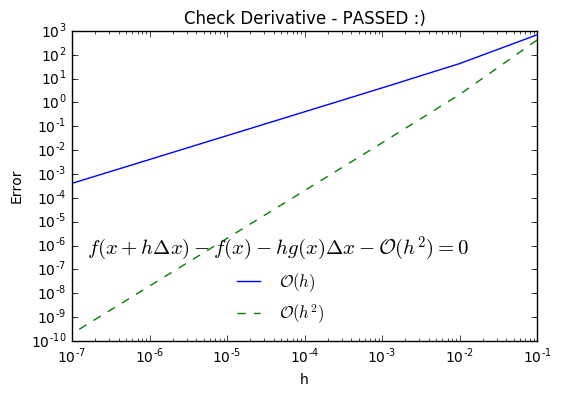

In [44]:
derchk = lambda m: (survey.dpred(m), lambda v: prob.Jvec(m, v))
passed = Tests.checkDerivative(derchk, m0, dx = m0*1.5)

In [14]:
# inv.run(m0)

In [15]:
beta = 0.3

In [24]:
np.ones(10).shape

(10, 1)

In [16]:
kerneleta = lambda t, eta: beta/t*((t/tau)**beta)*np.exp(-(t/tau)**beta)
kerneltau = lambda t, tau: -beta**2 * eta * ((t/tau)**beta) / (t*tau) * np.exp(-(t/tau)**beta) * (-(t/tau)**beta+1.)
kernelbeta = lambda t, beta: -eta/t*((t/tau)**beta)*np.exp(-(t/tau)**beta)*( beta*((t/tau)**beta)*np.log(t/tau)-beta*np.log(t/tau)-1.)

In [17]:
kernelfwdeta = lambda t, eta: ColeSEImpulse(t, eta, tau, beta)
kernelfwdtau = lambda t, tau: ColeSEImpulse(t, eta, tau, beta)
kernelfwdbeta = lambda t, beta: ColeSEImpulse(t, eta, tau, beta)

In [18]:
derChk_eta = lambda m: (kernelfwdeta(time, m), lambda v: kerneleta(time, m)*v )
derChk_tau = lambda m: (kernelfwdtau(time, m), lambda v: kerneltau(time, m)*v )
derChk_beta = lambda m: (kernelfwdbeta(time, m), lambda v: kernelbeta(time, m)*v )

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    1.406e+03     3.378e-13      nan
 1   1.00e-02    1.406e+02     4.011e-13      -0.075
 2   1.00e-03    1.406e+01     3.645e-13      0.042
 3   1.00e-04    1.406e+00     2.801e-13      0.114
 4   1.00e-05    1.406e-01     5.521e-13      -0.295
 5   1.00e-06    1.406e-02     4.866e-13      0.055
 6   1.00e-07    1.406e-03     1.936e-13      0.400
========================= PASS! =========================
You are awesome.



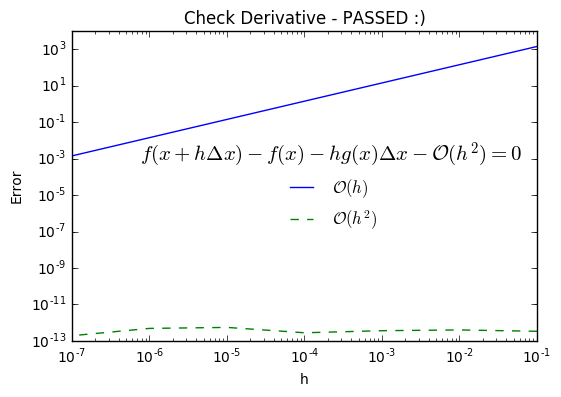

True

In [19]:
Tests.checkDerivative(derChk_eta, np.r_[beta])

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    2.355e+00     4.943e-01      nan
 1   1.00e-02    2.789e-01     6.044e-03      1.913
 2   1.00e-03    2.843e-02     6.184e-05      1.990
 3   1.00e-04    2.848e-03     6.198e-07      1.999
 4   1.00e-05    2.849e-04     6.199e-09      2.000
 5   1.00e-06    2.849e-05     6.199e-11      2.000
 6   1.00e-07    2.849e-06     6.189e-13      2.001
========================= PASS! =========================
You are awesome.



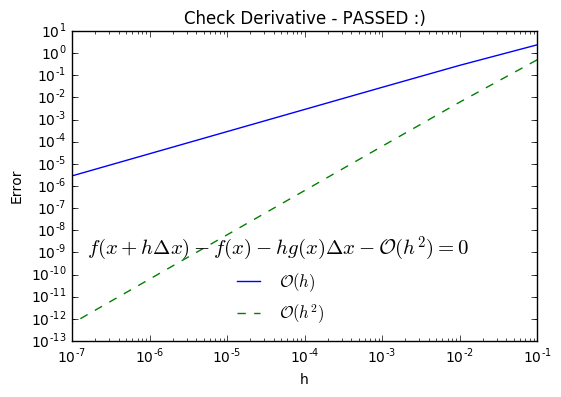

True

In [20]:
Tests.checkDerivative(derChk_tau, np.r_[beta])

==================== checkDerivative ====================
iter    h         |ft-f0|   |ft-f0-h*J0*dx|  Order
---------------------------------------------------------
 0   1.00e-01    4.144e+00     2.459e-01      nan
 1   1.00e-02    3.955e-01     2.768e-03      1.949
 2   1.00e-03    3.933e-02     2.801e-05      1.995
 3   1.00e-04    3.931e-03     2.804e-07      1.999
 4   1.00e-05    3.931e-04     2.804e-09      2.000
 5   1.00e-06    3.931e-05     2.805e-11      2.000
 6   1.00e-07    3.931e-06     2.844e-13      1.994
========================= PASS! =========================
Testing is important.



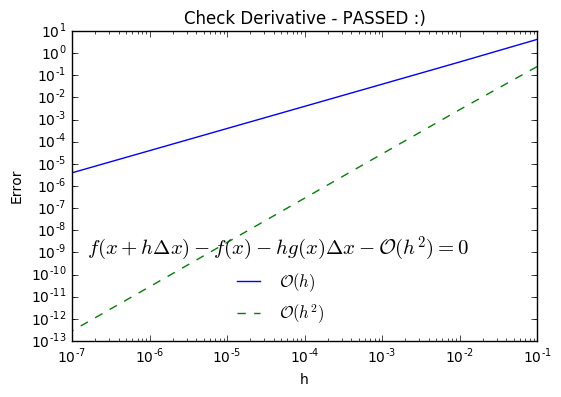

True

In [21]:
Tests.checkDerivative(derChk_beta, np.r_[beta])